- https://www.kaggle.com/mlg-ulb/creditcardfraud
- https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [3]:
data = pd.read_csv('input/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frequency')

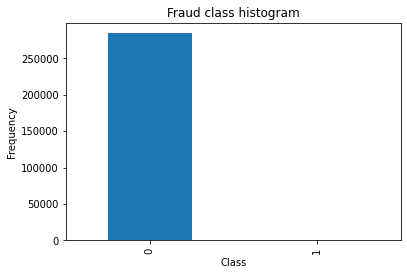

In [8]:
count_class = pd.value_counts(data['Class'], sort=True).sort_index()
count_class.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

### Approach
- We are not going to perform feature engineering in first instance. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount).
- We will then compare what happens when using resampling and when not using it. We will test this approach using a simple logistic regression classifier.
- We will evaluate the models by using some of the performance metrics mentioned above.
- We will repeat the best resampling/not resampling method, by tuning the parameters in the logistic regression classifier.
- We will finally perform classifications model using other classification algorithms.

### Setting our input and target variables + resampling.

#### 1. Normalising the amount column. The amount column is not in line with the anonimised features

In [23]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop(['Time', 'Amount'], axis=1, inplace = True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


#### 2. Assigning X and Y. No resampling.

#### 3. Resampling.
- As we mentioned earlier, there are several ways to resample skewed data. Apart from under and over sampling, there is a very popular approach called SMOTE (Synthetic Minority Over-Sampling Technique), which is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

- In this notebook, we will use traditional UNDER-sampling. I will probably try to implement SMOTE in future versions of the code, but for now I will use traditional undersamplig.

- The way we will under sample the dataset will be by creating a 50/50 ratio. This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of records with the minority class.

In [39]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [44]:
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

normal_indices = data[data.Class == 0].index

random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


### Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [49]:
!pip3 install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=00e1ea11f50ad23220dde22594ede9fde41eed2467dd79aae2fcccbd23630ebb
  Stored in directory: /Users/user/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print()
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


### Logistic regression classifier - Undersampled data

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

#### Very ad-hoc function to print K_fold_score

In [127]:
def printing_Kfold_score(x_train_data, y_train_data) : 
    kf = KFold(5, shuffle=False)
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    results_table = pd.DataFrame(index = range(len(c_param_range), 2), columns = ['C_parameter', 'Mean recall score'])
    results_table['C_parameter'] = c_param_range
    
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print()
    
        recall_accs = []
        
        fold = kf.split(x_train_data)
        for iteration, indices in enumerate(fold, start=1) :
            #print(indices)
            lr = LogisticRegression(C=c_param, penalty = 'l2')
            lr.fit(x_train_data.iloc[indices[0],:], y_train_data.iloc[indices[0],:].values.ravel())
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
        
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values, y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)
        
        results_table.loc[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
        
    results_table = results_table.astype({'Mean recall score' : 'float'})
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
        
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c
        

In [128]:
best_c = printing_Kfold_score(X_train_undersample, y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.8356164383561644
Iteration  2 : recall score =  0.8493150684931506
Iteration  3 : recall score =  0.8983050847457628
Iteration  4 : recall score =  0.9324324324324325
Iteration  5 : recall score =  0.8787878787878788

Mean recall score  0.8788913805630779

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.8767123287671232
Iteration  3 : recall score =  0.9661016949152542
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.8939393939393939

Mean recall score  0.9064028864121736

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.8904109589041096


In [135]:
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues) :
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else :
        1
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j], 
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predcited label')

#### Predictions on test set and plotting confusion matrix
We have been talking about using the recall metric as our proxy of how effective our predictive model is. Even though recall is still the recall we want to calculate, just bear mind in mind that the undersampled data hasn't got a skewness towards a certain class, which doesn't make recall metric as critical.

Recall metric in the testing dataset: 0.9252


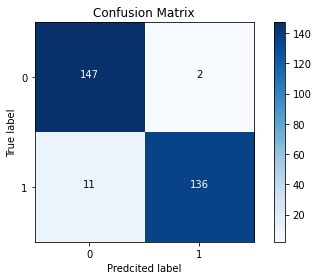

In [141]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# undersample 데이터를 통해 C_paramter만 구하고, 전체 데이터로 재학습
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel()) # 다차원을 1차원으로 풀기 :a1.ravel() # 또는 a2 = a1.reshape(-1) 또는 a2 = a1.flatten()
y_pred_undersample = lr.predict(X_test_undersample)

cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision=2) # floating point number

print("Recall metric in the testing dataset: {:.4f}".format(cnf_matrix[1, 1] / (cnf_matrix[1,0] + cnf_matrix[1,1]))) # tp / (fn + tp)

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')


Recall metric in the testing dataset: 0.9388


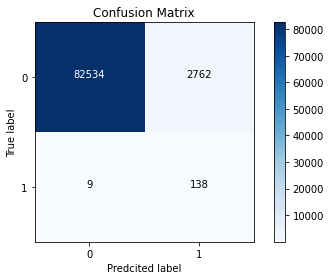

In [144]:
lr = LogisticRegression(C = best_c, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: {:.4f}".format(cnf_matrix[1, 1] / (cnf_matrix[1,0] + cnf_matrix[1,1]))) # tp / (fn + tp)

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

### Before continuing... changing classification threshold.
We have seen that by undersampling the data, our algorithm does a much better job at detecting fraud. I wanted also to show how can we tweak our final classification by changing the thresold.¶
- Initially, you build the classification model and then you predict unseen data using it.
- We previously used the "predict()" method to decided whether a record should belong to "1" or "0".
- There is another method "predict_proba()".
  - This method returns the probabilities for each class. The idea is that by changing the threshold to assign a record to class 1, we can control precision and recall.

Recall metric in the testing dataset: 0.9932
Recall metric in the testing dataset: 0.9524
Recall metric in the testing dataset: 0.9252
Recall metric in the testing dataset: 0.9048
Recall metric in the testing dataset: 0.8707
Recall metric in the testing dataset: 0.8503
Recall metric in the testing dataset: 0.8503
Recall metric in the testing dataset: 0.8163
Recall metric in the testing dataset: 0.7687


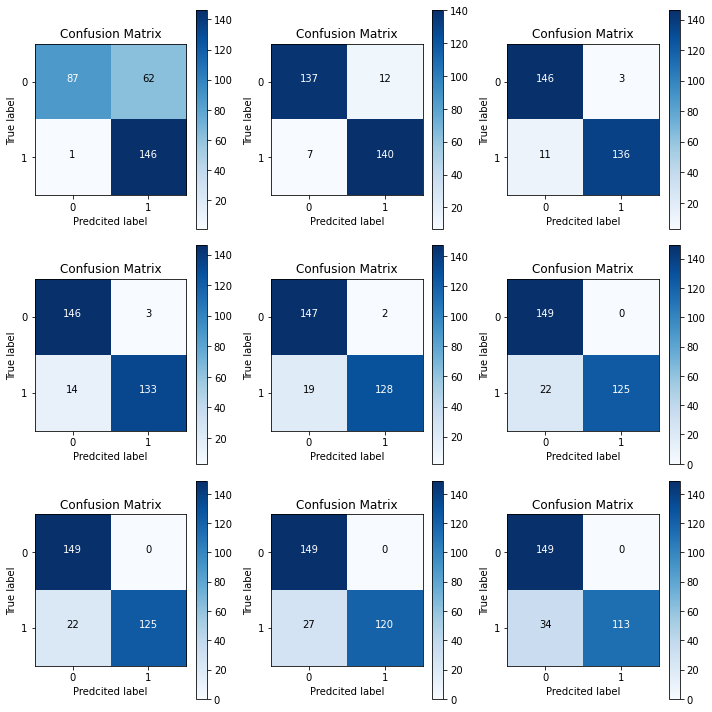

In [149]:
lr = LogisticRegression(C=0.01, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds :
    y_test_prediction_high_recall = y_pred_undersample_proba[:, 1] > i
    
    plt.subplot(3, 3, j)
    j += 1
    
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_prediction_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: {:.4f}".format(cnf_matrix[1, 1] / (cnf_matrix[1,0] + cnf_matrix[1,1]))) # tp / (fn + tp)

    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    
    ## 임계치를 낮출수록 recall은 올라가지만, precision이 내려감

### Investigate Precision-Recall curve and area under this curve.

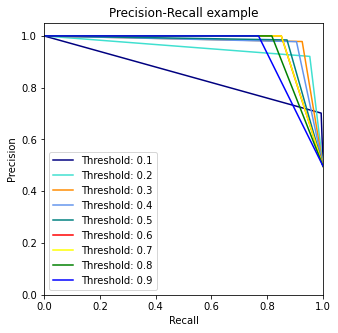

In [151]:
from itertools import cycle

lr = LogisticRegression(C=0.01, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i, color in zip(thresholds, colors) :
    y_test_prediction_prob = y_pred_undersample_proba[:, 1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample, y_test_prediction_prob)
    
    plt.plot(recall, precision, color=color, label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc='lower left')
    